### Hyperparameters:
| Hyperparameter       | Value   |
|----------------------|---------|
| num-filters          | 32      |
| num-bilstm-layer     | 2       |
| output-lstm-dim      | 64      |
| decay-rate           | 0.8     |
| learning-rate        | 0.01    |
| miniBatchSize        | 256     |
| filter-size          | 10 × 1  |
| input-lstm-dim       | 100     |
| L2Regularization     | 0.001   |
| optimizer            | Adam    |
| dropout              | 0.25    |
| maxEpochs            | 500     |

In [57]:
import sys
sys.path.append("..")

In [58]:
from tqdm import tqdm
import pandas as pd
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from utils.helper import *

In [45]:
df = pd.read_csv("../data/Final_Btc_Data_with_Indicators.csv", parse_dates=['Date'])

K = 5
df = scaled_data_vmd(df, _K=K)

# df = scaled_data(df)

target_col = "Price"
features = [col for col in df.columns if col != target_col and col != "Date"]

seq_len = 5
horizon = 1
X, y = create_sequences(df[features].values, df[target_col].values, seq_len, horizon)

In [46]:
batch_size = 256

train_loader, val_loader, test_loader = data_loaders(df, X, y, batch_size=batch_size)

In [47]:
input, target = next(iter(train_loader))

print(f"Input shape: {input.shape}")
print(f"Target shape: {target.shape}")

Input shape: torch.Size([256, 5, 84])
Target shape: torch.Size([256])


## CNN-BiLSTM

In [48]:
class CNNBiLSTM(nn.Module):
    def __init__(self, input_dim, num_filters=32, num_bilstm_layers=2, lstm_hidden=64, filter_size=(10, 1), input_lstm_dim=100, dropout_rate=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(
            in_channels=input_dim,
            out_channels=num_filters,
            kernel_size=filter_size[0],
            stride=1,
            padding=filter_size[0] // 2
        )

        self.proj = nn.Linear(num_filters, input_lstm_dim)

        self.relu = nn.ReLU()

        self.bilstm1 = nn.LSTM(
            input_size=input_lstm_dim,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.drop1 = nn.Dropout(dropout_rate)

        self.bilstm2 = nn.LSTM(
            input_size = 2 * lstm_hidden,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Linear(lstm_hidden * 2, 1)


    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))

        x = x.permute(0, 2, 1)
        x = self.relu(self.proj(x))

        # BiLSTM layers
        out, _ = self.bilstm1(x)
        out = self.drop1(out)
        out, _ = self.bilstm2(out)

        # take last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze(-1)

In [49]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [50]:
model = CNNBiLSTM(input_dim=len(features))

In [51]:
decay_rate = 0.8
num_epochs = 300
learning_rate = 0.001
l2_penalty = 0.001

In [52]:
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    # weight_decay=l2_penalty
)

# scheduler = torch.optim.lr_scheduler.ExponentialLR(
#     optimizer,
#     gamma=decay_rate
# )
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=decay_rate
)

In [ ]:
best_val_loss = float('inf')
patience = 10
patience_counter = 0

train_losses = []
val_losses = []

print(f"Training on device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

for epoch in range(num_epochs):

    print(f"{'='*40}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'-'*40}")

    model.train()
    train_loss = 0.0

    for batch_x, batch_y in tqdm(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in tqdm(val_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # scheduler.step()

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # torch.save(model.state_dict(), '../models/cnn_bilstm15.pth')
    else:
        patience_counter += 1

    # if epoch % 10 == 0 or epoch == num_epochs - 1:
    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch+1}')
        break

print(f'\nBest validation loss: {best_val_loss:.6f}')

Training on device: mps
Model parameters: 214661
Epoch 1/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 21.39it/s]


Epoch [1/300] - Train Loss: 1.143308, Val Loss: 20.203559
Epoch 2/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 235.71it/s]


Epoch [2/300] - Train Loss: 0.874408, Val Loss: 17.412788
Epoch 3/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 224.04it/s]


Epoch [3/300] - Train Loss: 0.603816, Val Loss: 13.368660
Epoch 4/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 233.54it/s]


Epoch [4/300] - Train Loss: 0.402478, Val Loss: 8.646765
Epoch 5/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 166.83it/s]


Epoch [5/300] - Train Loss: 0.287722, Val Loss: 5.238508
Epoch 6/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 243.45it/s]


Epoch [6/300] - Train Loss: 0.148544, Val Loss: 3.530843
Epoch 7/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 170.50it/s]


Epoch [7/300] - Train Loss: 0.070051, Val Loss: 1.126953
Epoch 8/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 251.70it/s]


Epoch [8/300] - Train Loss: 0.037687, Val Loss: 0.606063
Epoch 9/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 206.12it/s]


Epoch [9/300] - Train Loss: 0.018659, Val Loss: 0.327614
Epoch 10/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 231.00it/s]


Epoch [10/300] - Train Loss: 0.026763, Val Loss: 0.229494
Epoch 11/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 264.65it/s]


Epoch [11/300] - Train Loss: 0.184618, Val Loss: 2.489655
Epoch 12/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 244.25it/s]


Epoch [12/300] - Train Loss: 0.070621, Val Loss: 0.309228
Epoch 13/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 262.78it/s]


Epoch [13/300] - Train Loss: 0.041791, Val Loss: 0.804916
Epoch 14/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 230.25it/s]


Epoch [14/300] - Train Loss: 0.017952, Val Loss: 0.237945
Epoch 15/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 237.99it/s]


Epoch [15/300] - Train Loss: 0.010051, Val Loss: 0.239697
Epoch 16/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 208.40it/s]


Epoch [16/300] - Train Loss: 0.008342, Val Loss: 0.228411
Epoch 17/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 231.79it/s]


Epoch [17/300] - Train Loss: 0.006077, Val Loss: 0.207639
Epoch 18/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 248.16it/s]


Epoch [18/300] - Train Loss: 0.005528, Val Loss: 0.218945
Epoch 19/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 212.25it/s]


Epoch [19/300] - Train Loss: 0.005564, Val Loss: 0.206074
Epoch 20/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 270.52it/s]


Epoch [20/300] - Train Loss: 0.006816, Val Loss: 0.222009
Epoch 21/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 281.29it/s]


Epoch [21/300] - Train Loss: 0.008557, Val Loss: 0.198501
Epoch 22/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 268.17it/s]


Epoch [22/300] - Train Loss: 0.013936, Val Loss: 0.313580
Epoch 23/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 248.92it/s]


Epoch [23/300] - Train Loss: 0.017015, Val Loss: 0.223471
Epoch 24/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 248.39it/s]


Epoch [24/300] - Train Loss: 0.024989, Val Loss: 0.479926
Epoch 25/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 265.25it/s]


Epoch [25/300] - Train Loss: 0.017196, Val Loss: 0.242344
Epoch 26/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 250.63it/s]


Epoch [26/300] - Train Loss: 0.012674, Val Loss: 0.358096
Epoch 27/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 260.61it/s]


Epoch [27/300] - Train Loss: 0.007128, Val Loss: 0.188887
Epoch 28/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 262.12it/s]


Epoch [28/300] - Train Loss: 0.004975, Val Loss: 0.244629
Epoch 29/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 256.91it/s]


Epoch [29/300] - Train Loss: 0.003702, Val Loss: 0.195177
Epoch 30/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 275.41it/s]


Epoch [30/300] - Train Loss: 0.003574, Val Loss: 0.204638
Epoch 31/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 268.45it/s]


Epoch [31/300] - Train Loss: 0.002906, Val Loss: 0.199678
Epoch 32/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 259.50it/s]


Epoch [32/300] - Train Loss: 0.003232, Val Loss: 0.200441
Epoch 33/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 265.93it/s]


Epoch [33/300] - Train Loss: 0.002923, Val Loss: 0.191911
Epoch 34/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 270.92it/s]


Epoch [34/300] - Train Loss: 0.002761, Val Loss: 0.195094
Epoch 35/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 259.30it/s]


Epoch [35/300] - Train Loss: 0.003120, Val Loss: 0.205373
Epoch 36/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 250.77it/s]


Epoch [36/300] - Train Loss: 0.004307, Val Loss: 0.173073
Epoch 37/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 273.08it/s]


Epoch [37/300] - Train Loss: 0.009147, Val Loss: 0.293863
Epoch 38/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 260.21it/s]


Epoch [38/300] - Train Loss: 0.016859, Val Loss: 0.214263
Epoch 39/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 257.76it/s]


Epoch [39/300] - Train Loss: 0.038135, Val Loss: 0.648128
Epoch 40/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 266.38it/s]


Epoch [40/300] - Train Loss: 0.031711, Val Loss: 0.315243
Epoch 41/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 276.47it/s]


Epoch [41/300] - Train Loss: 0.028283, Val Loss: 0.635237
Epoch 42/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 233.32it/s]


Epoch [42/300] - Train Loss: 0.009724, Val Loss: 0.205249
Epoch 43/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 245.27it/s]


Epoch [43/300] - Train Loss: 0.004044, Val Loss: 0.246463
Epoch 44/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 243.64it/s]


Epoch [44/300] - Train Loss: 0.003536, Val Loss: 0.230664
Epoch 45/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 219.68it/s]


Epoch [45/300] - Train Loss: 0.002801, Val Loss: 0.211040
Epoch 46/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 114.94it/s]


Epoch [46/300] - Train Loss: 0.002338, Val Loss: 0.232274
Epoch 47/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 259.40it/s]


Epoch [47/300] - Train Loss: 0.002429, Val Loss: 0.215046
Epoch 48/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 243.19it/s]


Epoch [48/300] - Train Loss: 0.002066, Val Loss: 0.213933
Epoch 49/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 244.32it/s]


Epoch [49/300] - Train Loss: 0.002297, Val Loss: 0.213127
Epoch 50/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 239.41it/s]


Epoch [50/300] - Train Loss: 0.001945, Val Loss: 0.213125
Epoch 51/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 250.09it/s]


Epoch [51/300] - Train Loss: 0.002189, Val Loss: 0.210887
Epoch 52/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 222.37it/s]


Epoch [52/300] - Train Loss: 0.001849, Val Loss: 0.205185
Epoch 53/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 250.97it/s]


Epoch [53/300] - Train Loss: 0.001884, Val Loss: 0.211847
Epoch 54/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 248.39it/s]


Epoch [54/300] - Train Loss: 0.002061, Val Loss: 0.198816
Epoch 55/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 257.40it/s]


Epoch [55/300] - Train Loss: 0.002162, Val Loss: 0.222610
Epoch 56/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 246.64it/s]


Epoch [56/300] - Train Loss: 0.002678, Val Loss: 0.189929
Epoch 57/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 243.81it/s]


Epoch [57/300] - Train Loss: 0.003837, Val Loss: 0.243691
Epoch 58/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 251.29it/s]


Epoch [58/300] - Train Loss: 0.005943, Val Loss: 0.185682
Epoch 59/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 237.64it/s]


Epoch [59/300] - Train Loss: 0.011950, Val Loss: 0.365896
Epoch 60/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 266.13it/s]


Epoch [60/300] - Train Loss: 0.017341, Val Loss: 0.228244
Epoch 61/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 228.44it/s]


Epoch [61/300] - Train Loss: 0.031307, Val Loss: 0.612417
Epoch 62/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 280.27it/s]


Epoch [62/300] - Train Loss: 0.023494, Val Loss: 0.273248
Epoch 63/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 268.66it/s]


Epoch [63/300] - Train Loss: 0.023287, Val Loss: 0.553978
Epoch 64/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 233.92it/s]


Epoch [64/300] - Train Loss: 0.010084, Val Loss: 0.216783
Epoch 65/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 244.94it/s]


Epoch [65/300] - Train Loss: 0.005235, Val Loss: 0.309665
Epoch 66/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 251.80it/s]

Epoch [66/300] - Train Loss: 0.002948, Val Loss: 0.223885
Early stopping triggered after epoch 66

Best validation loss: 0.173073


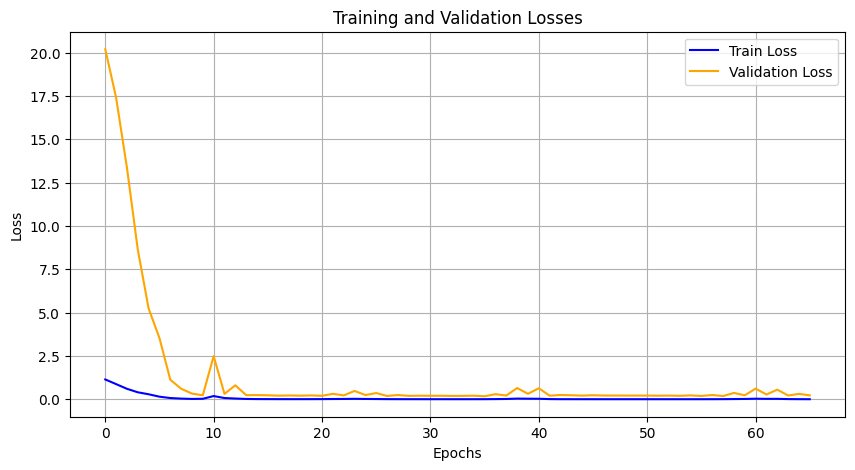

In [54]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid()
plt.show()

In [55]:
# Test phase
model.eval()
test_loss = 0.0
test_predictions = []
test_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

        test_predictions.extend(outputs.cpu().numpy())
        test_targets.extend(batch_y.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.6f}')

# Convert to numpy arrays for analysis
test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)

Test Loss: 0.411594


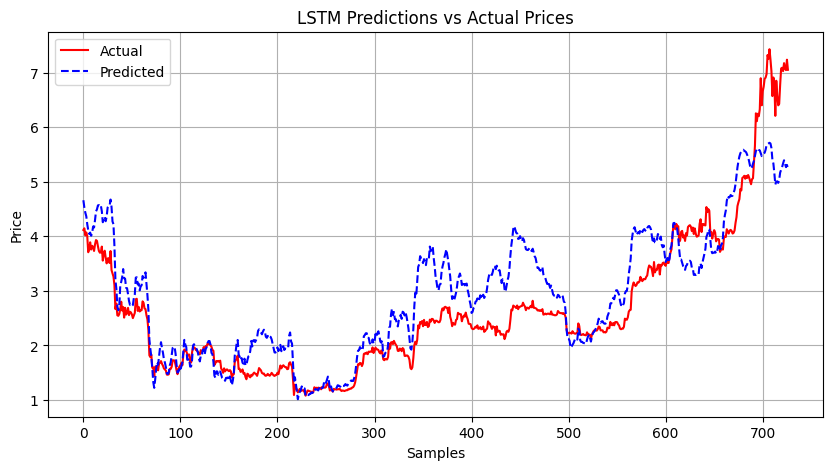

In [56]:
# plot predictions vs targets
plt.figure(figsize=(10, 5))
plt.plot(test_targets, label='Actual', color='red')
plt.plot(test_predictions, label='Predicted', color='blue', linestyle='--')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.title('LSTM Predictions vs Actual Prices')
plt.legend()
plt.grid()
plt.show()